without PE

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, MultiHeadAttention
# Create a figure to visualize the training history

import numpy as np

# 1️⃣ Define Fixed Word Embeddings (Predefined & Not Trainable)
eng_vocab = {"I": 0, "love": 1, "cats": 2}
chn_vocab = {"我": 0, "喜": 1, "歡": 2, "貓": 3}  # "喜" and "歡" are separate

eng_vocab_size = len(eng_vocab)  
chn_vocab_size = len(chn_vocab)  
seq_len = 3  # English sequence length
target_seq_len = 4  # Chinese sequence length (now 4 words)
embed_dim = 8  # Word vector size
num_heads = 1  # Single-head attention

# **Fixed Word Embeddings (Manually Set)**
eng_embeddings = np.array([
    [0.1, 0.3, -0.5, 0.7, 0.2, -0.4, 0.6, -0.1],  # "I"
    [0.2, -0.1, 0.6, -0.3, 0.5, 0.4, -0.2, 0.1],  # "love"
    [-0.4, 0.8, 0.2, -0.6, 0.3, -0.7, 0.9, 0.0]   # "cats"
])

chn_embeddings = np.array([
    [-0.2, 0.5, 0.1, -0.3, 0.7, 0.6, -0.8, 0.2],  # "我"
    [0.3, -0.7, 0.8, 0.2, -0.6, 0.1, 0.5, -0.4],  # "喜"
    [0.1, 0.6, -0.2, -0.5, 0.8, -0.3, 0.4, -0.7], # "歡"
    [0.5, 0.4, -0.1, -0.6, 0.2, -0.9, 0.7, 0.3]   # "貓"
])

# 2️⃣ Define Encoder (Self-Attention)
encoder_inputs = Input(shape=(seq_len, embed_dim))  # Fixed input embeddings
encoder_attention = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
encoder_output = encoder_attention(encoder_inputs, encoder_inputs)  # Self-attention in encoder

# 3️⃣ Define Decoder with Feedback
decoder_inputs = Input(shape=(target_seq_len, embed_dim))  # Decoder input
decoder_attention = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
decoder_output = decoder_attention(decoder_inputs, encoder_output)  # Decoder attends to encoder

# 4️⃣ Fully Connected Output Layer (Predicts Chinese Words)
dense_layer = Dense(chn_vocab_size, activation="softmax")  # Outputs probabilities for each word
outputs = dense_layer(decoder_output)

# 5️⃣ Compile the Model
model = keras.Model(inputs=[encoder_inputs, decoder_inputs], outputs=outputs)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# 6️⃣ Prepare Training Data (Using Fixed Embeddings)
X_train_eng = np.array([eng_embeddings])  # Fixed embeddings for "I love cats"
X_train_chn = np.zeros((1, target_seq_len, embed_dim))  # Empty decoder input at start

y_train = np.array([
    [0, 1, 2, 3]  # "我 喜 歡 貓" (Target sequence)
])

# 7️⃣ Train the Model
model.fit([X_train_eng, X_train_chn], y_train, epochs=1000, batch_size=1)

# 8️⃣ Test Translation (Autoregressive Generation)
def translate_sentence():
    encoder_input = np.array([eng_embeddings])  # Fixed English embeddings
    decoder_input = np.zeros((1, target_seq_len, embed_dim))  # Start with empty decoder input

    translated_sentence = []
    
    for i in range(target_seq_len):  # Generate word-by-word
        pred_probs = model.predict([encoder_input, decoder_input])[0, i, :]
        predicted_word_index = np.argmax(pred_probs)  # Select highest probability word
        translated_word = list(chn_vocab.keys())[list(chn_vocab.values()).index(predicted_word_index)]
        
        translated_sentence.append(translated_word)
        
        decoder_input[0, i, :] = chn_embeddings[predicted_word_index]  # Feed output back into decoder

    return " ".join(translated_sentence)

# Generate Translation
generated_translation = translate_sentence()
print("Predicted Translation:", generated_translation)  # Expected: "我 喜 歡 貓"

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.title('Model Loss During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid(True)
plt.show()



KeyboardInterrupt: 

with one-hot PE

In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, MultiHeadAttention
import numpy as np

# 1️⃣ Define Fixed Word Embeddings (Predefined & Not Trainable)
eng_vocab = {"I": 0, "love": 1, "cats": 2}
chn_vocab = {"我": 0, "喜": 1, "歡": 2, "貓": 3}  # "喜" and "歡" are separate

eng_vocab_size = len(eng_vocab)  
chn_vocab_size = len(chn_vocab)  
seq_len = 3  # English sequence length
target_seq_len = 4  # Chinese sequence length (now 4 words)
embed_dim = 6  # Word vector size reduced to 6
num_heads = 1  # Single-head attention

# **Fixed Word Embeddings (Manually Set, 6D)**
eng_embeddings = np.array([
    [0.1, 0.3, -0.5, 0.7, 0.2, -0.4],  # "I"
    [0.2, -0.1, 0.6, -0.3, 0.5, 0.4],  # "love"
    [-0.4, 0.8, 0.2, -0.6, 0.3, -0.7]   # "cats"
])

chn_embeddings = np.array([
    [-0.2, 0.5, 0.1, -0.3, 0.7, 0.6],  # "我"
    [0.3, -0.7, 0.8, 0.2, -0.6, 0.1],  # "喜"
    [0.1, 0.6, -0.2, -0.5, 0.8, -0.3], # "歡"
    [0.5, 0.4, -0.1, -0.6, 0.2, -0.9]  # "貓"
])

# **Extended Fixed Positional Encoding (6D One-Hot)**
pos_encoding = np.array([
    [1, 0, 0, 0, 0, 0],  # Position 0
    [0, 1, 0, 0, 0, 0],  # Position 1
    [0, 0, 1, 0, 0, 0],  # Position 2
    [0, 0, 0, 1, 0, 0],  # Position 3
    [0, 0, 0, 0, 1, 0],  # Position 4
    [0, 0, 0, 0, 0, 1]   # Position 5
])

# 2️⃣ Define Encoder (Self-Attention)
encoder_inputs = Input(shape=(seq_len, embed_dim))  # Fixed input embeddings
encoder_positional = Input(shape=(seq_len, embed_dim))  # Positional encoding
encoder_combined = encoder_inputs + encoder_positional  # Add position info

encoder_attention = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
encoder_output = encoder_attention(encoder_combined, encoder_combined)  # Self-attention

# 3️⃣ Define Decoder with Feedback
decoder_inputs = Input(shape=(target_seq_len, embed_dim))  # Decoder input
decoder_positional = Input(shape=(target_seq_len, embed_dim))  # Positional encoding
decoder_combined = decoder_inputs + decoder_positional  # Add position info

decoder_attention = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
decoder_output = decoder_attention(decoder_combined, encoder_output)  # Decoder attends to encoder

# 4️⃣ Fully Connected Output Layer (Predicts Chinese Words)
dense_layer = Dense(chn_vocab_size, activation="softmax")  # Outputs probabilities for each word
outputs = dense_layer(decoder_output)

# 5️⃣ Compile the Model
model = keras.Model(inputs=[encoder_inputs, encoder_positional, decoder_inputs, decoder_positional], outputs=outputs)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# 6️⃣ Prepare Training Data (Using Fixed Embeddings)
X_train_eng = np.array([eng_embeddings])  # Fixed embeddings for "I love cats"
X_train_eng_pos = np.array([pos_encoding[:seq_len]])  # English positional encoding
X_train_chn = np.zeros((1, target_seq_len, embed_dim)) + pos_encoding[:target_seq_len]  # Decoder input gets PE
X_train_chn_pos = np.array([pos_encoding[:target_seq_len]])  # Chinese positional encoding

y_train = np.array([
    [0, 1, 2, 3]  # "我 喜 歡 貓" (Target sequence)
])

# 7️⃣ Train the Model
model.fit([X_train_eng, X_train_eng_pos, X_train_chn, X_train_chn_pos], y_train, epochs=100, batch_size=1)

# 8️⃣ Test Translation (Autoregressive Generation)
def translate_sentence():
    encoder_input = np.array([eng_embeddings])  # Fixed English embeddings
    encoder_input_pos = np.array([pos_encoding[:seq_len]])  # Fixed positional encoding
    decoder_input = np.zeros((1, target_seq_len, embed_dim)) + pos_encoding[:target_seq_len]  # Start with PE
    decoder_input_pos = np.array([pos_encoding[:target_seq_len]])  # Fixed decoder positional encoding

    translated_sentence = []
    
    for i in range(target_seq_len):  # Generate word-by-word
        pred_probs = model.predict([encoder_input, encoder_input_pos, decoder_input, decoder_input_pos])[0, i, :]
        predicted_word_index = np.argmax(pred_probs)  # Select highest probability word
        translated_word = list(chn_vocab.keys())[list(chn_vocab.values()).index(predicted_word_index)]
        
        translated_sentence.append(translated_word)
        
        # Add positional encoding dynamically
        decoder_input[0, i, :] = chn_embeddings[predicted_word_index] + pos_encoding[i + 3]  # Apply PE at correct step

    return " ".join(translated_sentence)

# Generate Translation
generated_translation = translate_sentence()
print("Predicted Translation:", generated_translation)  # Expected: "我 喜 歡 貓"


Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.2500 - loss: 1.3925
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.2500 - loss: 1.3915
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.2500 - loss: 1.3906
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.2500 - loss: 1.3898
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.2500 - loss: 1.3891
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.2500 - loss: 1.3885
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.2500 - loss: 1.3880
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.2500 - loss: 1.3876
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.2500 - loss: 1.3873
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.2500 - loss: 1.3870
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.2500 - loss: 1.3868
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.2500 - loss

IndexError: index 6 is out of bounds for axis 0 with size 6

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, MultiHeadAttention, Embedding
import numpy as np

# 1️⃣ Define Transformer-Style Sinusoidal Positional Encoding
def positional_encoding(seq_len, embed_dim):
    PE = np.zeros((seq_len, embed_dim))
    for pos in range(seq_len):
        for i in range(0, embed_dim, 2):
            denominator = np.power(10000, (2 * i) / embed_dim)
            PE[pos, i] = np.sin(pos / denominator)  # Even indices: sine function
            if i + 1 < embed_dim:
                PE[pos, i + 1] = np.cos(pos / denominator)  # Odd indices: cosine function
    return PE

# 2️⃣ Define Vocabulary & Parameters
eng_vocab = {"I": 0, "love": 1, "cats": 2}
chn_vocab = {"我": 0, "喜": 1, "歡": 2, "貓": 3}

eng_vocab_size = len(eng_vocab)  
chn_vocab_size = len(chn_vocab)  
seq_len = 3  # Input sentence length
target_seq_len = 4  # Output sentence length
embed_dim = 6  # Word embedding & PE dimension
num_heads = 1  # Only one attention head

# 3️⃣ Generate Transformer-Style Positional Encoding
PE_eng = positional_encoding(seq_len, embed_dim)  # PE for English
PE_chn = positional_encoding(target_seq_len, embed_dim)  # PE for Chinese

# 4️⃣ Define Trainable Word Embeddings
embedding_layer_eng = Embedding(input_dim=eng_vocab_size, output_dim=embed_dim, trainable=True)
embedding_layer_chn = Embedding(input_dim=chn_vocab_size, output_dim=embed_dim, trainable=True)

# 5️⃣ Define Encoder (Self-Attention)
encoder_inputs = Input(shape=(seq_len,))  # Word indices
embedded_inputs = embedding_layer_eng(encoder_inputs)  # Convert indices to embeddings
encoder_positional = Input(shape=(seq_len, embed_dim))  # Positional Encoding
encoder_combined = embedded_inputs + encoder_positional  # Add PE to embeddings

encoder_attention = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
encoder_output = encoder_attention(encoder_combined, encoder_combined)  # Self-attention

# 6️⃣ Define Decoder
decoder_inputs = Input(shape=(target_seq_len,))  # Target word indices
embedded_decoder_inputs = embedding_layer_chn(decoder_inputs)  # Convert to embeddings
decoder_positional = Input(shape=(target_seq_len, embed_dim))  # Positional Encoding
decoder_combined = embedded_decoder_inputs + decoder_positional  # Add PE to embeddings

decoder_attention = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
decoder_output = decoder_attention(decoder_combined, encoder_output)  # Attend to encoder

# 7️⃣ Fully Connected Output Layer (Predicts Next Words)
dense_layer = Dense(chn_vocab_size, activation="softmax")  # Outputs probabilities
outputs = dense_layer(decoder_output)

# 8️⃣ Compile the Model
model = keras.Model(inputs=[encoder_inputs, encoder_positional, decoder_inputs, decoder_positional], outputs=outputs)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# 9️⃣ Prepare Training Data (Single Example)
X_train_eng = np.array([[eng_vocab["I"], eng_vocab["love"], eng_vocab["cats"]]])  # "I love cats"
X_train_chn = np.array([[chn_vocab["我"], chn_vocab["喜"], chn_vocab["歡"], chn_vocab["貓"]]])  # "我 喜 歡 貓"

X_train_eng_pos = np.tile(PE_eng, (1, 1, 1))  # Positional Encoding for English
X_train_chn_pos = np.tile(PE_chn, (1, 1, 1))  # Positional Encoding for Chinese

# 🔟 Train the Model
model.fit([X_train_eng, X_train_eng_pos, X_train_chn, X_train_chn_pos], X_train_chn, epochs=100, batch_size=1)

# 🔟 Test Translation (Autoregressive Generation)
def translate_sentence(input_sentence):
    encoder_input = np.array([[eng_vocab[word] for word in input_sentence]])  # Convert words to indices
    encoder_input_pos = np.tile(PE_eng, (1, 1, 1))  # Use fixed PE

    decoder_input = np.zeros((1, target_seq_len))  # Start with empty decoder input
    decoder_input_pos = np.tile(PE_chn, (1, 1, 1))  # Use fixed PE

    translated_sentence = []
    
    for i in range(target_seq_len):
        pred_probs = model.predict([encoder_input, encoder_input_pos, decoder_input, decoder_input_pos])[0, i, :]
        predicted_word_index = np.argmax(pred_probs)  # Select highest probability word
        translated_word = list(chn_vocab.keys())[list(chn_vocab.values()).index(predicted_word_index)]
        
        translated_sentence.append(translated_word)
        decoder_input[0, i] = predicted_word_index  # Feed output back to decoder

    return " ".join(translated_sentence)

# 🔟 Run Translation
print("Predicted Translation:", translate_sentence(["I", "love", "cats"]))  # Expected: "我 喜 歡 貓"


2025-03-06 22:30:48.429354: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.2500 - loss: 1.3868
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.2500 - loss: 1.3865
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.2500 - loss: 1.3864
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.2500 - loss: 1.3864
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.2500 - loss: 1.3863
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.2500 - loss: 1.3863
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.2500 - loss: 1.3863
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.2500 - loss: 1.3863
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.2500 - loss: 1.3863
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.2500 - loss: 1.3864
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.2500 - loss: 1.3864
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.2500 

sentimental analysis:


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Embedding, Dense, Layer, Flatten
import numpy as np

# Define hyperparameters
VOCAB_SIZE = 20  # 20 unique tokens
EMBED_DIM = 4    # Each word is a 4D vector
SEQ_LENGTH = 3   # Short sequence length
BATCH_SIZE = 32
EPOCHS = 50

# Dummy dataset (random sequences and binary labels)
np.random.seed(42)
X_train = np.random.randint(0, VOCAB_SIZE, size=(1000, SEQ_LENGTH))
y_train = np.random.randint(0, 2, size=(1000, 1))

X_val = np.random.randint(0, VOCAB_SIZE, size=(200, SEQ_LENGTH))
y_val = np.random.randint(0, 2, size=(200, 1))

class SelfAttention(Layer):
    def __init__(self, embed_dim):
        super(SelfAttention, self).__init__()
        self.embed_dim = embed_dim

        # Learnable weight matrices for Query, Key, and Value
        self.W_q = Dense(embed_dim, use_bias=False)
        self.W_k = Dense(embed_dim, use_bias=False)
        self.W_v = Dense(embed_dim, use_bias=False)

    def call(self, inputs):
        # Compute Q, K, V matrices
        Q = self.W_q(inputs)  # (batch_size, seq_length, embed_dim)
        K = self.W_k(inputs)  # (batch_size, seq_length, embed_dim)
        V = self.W_v(inputs)  # (batch_size, seq_length, embed_dim)

        # Compute scaled dot-product attention
        scores = tf.matmul(Q, K, transpose_b=True) / tf.sqrt(tf.cast(self.embed_dim, tf.float32))
        attention_weights = tf.nn.softmax(scores, axis=-1)  # (batch_size, seq_length, seq_length)
        output = tf.matmul(attention_weights, V)  # (batch_size, seq_length, embed_dim)

        return output

# Define model
inputs = keras.Input(shape=(SEQ_LENGTH,))

# Embedding Layer
embedding = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM)(inputs)

# Self-Attention Layer
attention_output = SelfAttention(EMBED_DIM)(embedding)

# Flatten the output (or use pooling instead)
flattened = Flatten()(attention_output)

# Fully Connected Layer
fc_output = Dense(1, activation='sigmoid')(flattened)

# Compile the model
model = keras.Model(inputs=inputs, outputs=fc_output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE)
test_sentence = np.array([[3, 5, 7]])  # Example sequence of token indices
predicted_sentiment = model.predict(test_sentence)
print("Predicted Sentiment Score:", predicted_sentiment[0, 0])

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Embedding, Dense, Layer, GlobalAveragePooling1D
import numpy as np

# Define hyperparameters
VOCAB_SIZE = 20   # Number of unique tokens
EMBED_DIM = 4     # Dimension of word embeddings
SEQ_LENGTH = 3    # Number of words per sentence
BATCH_SIZE = 32
EPOCHS = 100

# Dummy dataset (random sequences and binary labels)
np.random.seed(42)
X_train = np.random.randint(0, VOCAB_SIZE, size=(1000, SEQ_LENGTH))
y_train = np.random.randint(0, 2, size=(1000, 1))

X_val = np.random.randint(0, VOCAB_SIZE, size=(200, SEQ_LENGTH))
y_val = np.random.randint(0, 2, size=(200, 1))


# Define Self-Attention Layer
class SelfAttention(Layer):
    def __init__(self, embed_dim):
        super(SelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.W_q = Dense(embed_dim, use_bias=False)
        self.W_k = Dense(embed_dim, use_bias=False)
        self.W_v = Dense(embed_dim, use_bias=False)

    def call(self, inputs):
        Q = self.W_q(inputs)
        K = self.W_k(inputs)
        V = self.W_v(inputs)

        scores = tf.matmul(Q, K, transpose_b=True) / tf.sqrt(tf.cast(self.embed_dim, tf.float32))
        attention_weights = tf.nn.softmax(scores, axis=-1)
        output = tf.matmul(attention_weights, V)
        
        return output


# Define Model
inputs = keras.Input(shape=(SEQ_LENGTH,))

# Trainable Embedding Layer (Joint Training)
embedding = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM, trainable=True)(inputs)

# Self-Attention Layer
attention_output = SelfAttention(EMBED_DIM)(embedding)

# Global Average Pooling (better than Flatten for small models)
pooled_output = GlobalAveragePooling1D()(attention_output)

# Fully Connected Layer
fc_output = Dense(8, activation='relu')(pooled_output)
fc_output = Dense(1, activation='sigmoid')(fc_output)

# Compile Model
model = keras.Model(inputs=inputs, outputs=fc_output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train Model
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE)

# Test Prediction
test_sentence = np.array([[3, 5, 7]])  # Example sequence of token indices
predicted_sentiment = model.predict(test_sentence)
print("Predicted Sentiment Score:", predicted_sentiment[0, 0])


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 3, 4)           │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ self_attention (SelfAttention)  │ (None, 3, 4)           │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 4)              │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 177 (708.00 B)

 Trainable params: 177 (708.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5100 - loss: 0.6932 - val_accuracy: 0.4650 - val_loss: 0.6941
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4995 - loss: 0.6930 - val_accuracy: 0.4600 - val_loss: 0.6946
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4997 - loss: 0.6929 - val_accuracy: 0.4600 - val_loss: 0.6951
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5218 - loss: 0.6917 - val_accuracy: 0.4600 - val_loss: 0.6960
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5105 - loss: 0.6922 - val_accuracy: 0.4600 - val_loss: 0.6964
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5028 - loss: 0.6919 - val_accuracy: 0.4550 - val_loss: 0.6962
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5067 - loss: 0.6911 - val_accuracy: 0.4450 - val_loss: 0.6975
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5130 - loss: 0.6921 - val_accuracy: 0.4600 - 

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6051 - loss: 0.6603 - val_accuracy: 0.4750 - val_loss: 0.7292
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5984 - loss: 0.6615 - val_accuracy: 0.4750 - val_loss: 0.7297
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6031 - loss: 0.6552 - val_accuracy: 0.4550 - val_loss: 0.7296
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5809 - loss: 0.6701 - val_accuracy: 0.4650 - val_loss: 0.7289
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6171 - loss: 0.6493 - val_accuracy: 0.4700 - val_loss: 0.7301
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5806 - loss: 0.6658 - val_accuracy: 0.4700 - val_loss: 0.7313
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6269 - loss: 0.6481 - val_accuracy: 0.4700 - val_loss: 0.7333
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6081 - loss: 0.6448 - val_accuracy: 0.4650 - v

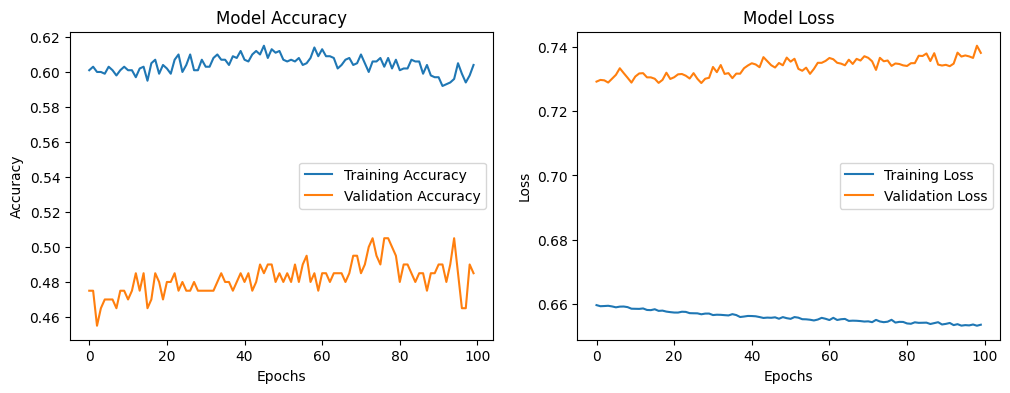

In [3]:
import matplotlib.pyplot as plt

# Train Model and store training history
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE)

# Plot Accuracy and Loss Curves
def plot_training_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Plot accuracy
    axes[0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0].set_title('Model Accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()

    # Plot loss
    axes[1].plot(history.history['loss'], label='Training Loss')
    axes[1].plot(history.history['val_loss'], label='Validation Loss')
    axes[1].set_title('Model Loss')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].legend()

    plt.show()

# Call the function to display the graphs
plot_training_history(history)


In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Embedding, Dense, Layer, GlobalAveragePooling1D, LayerNormalization, Add, Dropout
import numpy as np

# Define hyperparameters
VOCAB_SIZE = 20   # Number of unique tokens
EMBED_DIM = 8     # Increased from 4 to 8
SEQ_LENGTH = 5    # Increased from 3 to 5
BATCH_SIZE = 32
EPOCHS = 500
DROPOUT_RATE = 0.1  # Regularization

# Dummy dataset (random sequences and binary labels)
np.random.seed(42)
X_train = np.random.randint(0, VOCAB_SIZE, size=(1000, SEQ_LENGTH))
y_train = np.random.randint(0, 2, size=(1000, 1))

X_val = np.random.randint(0, VOCAB_SIZE, size=(200, SEQ_LENGTH))
y_val = np.random.randint(0, 2, size=(200, 1))


# Define Improved Self-Attention Layer with Residual Connection & Layer Norm
class SelfAttention(Layer):
    def __init__(self, embed_dim):
        super(SelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.W_q = Dense(embed_dim, use_bias=False)
        self.W_k = Dense(embed_dim, use_bias=False)
        self.W_v = Dense(embed_dim, use_bias=False)
        self.layer_norm = LayerNormalization()
        self.add = Add()

    def call(self, inputs):
        Q = self.W_q(inputs)
        K = self.W_k(inputs)
        V = self.W_v(inputs)

        # Compute scaled dot-product attention
        scores = tf.matmul(Q, K, transpose_b=True) / tf.sqrt(tf.cast(self.embed_dim, tf.float32))
        attention_weights = tf.nn.softmax(scores, axis=-1)
        attention_output = tf.matmul(attention_weights, V)

        # Residual connection: Add input embeddings to attention output
        output = self.add([attention_output, inputs])
        
        # Apply layer normalization
        return self.layer_norm(output)


# Define Model
inputs = keras.Input(shape=(SEQ_LENGTH,))

# Trainable Embedding Layer (Joint Training)
embedding = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM, trainable=True)(inputs)

# Self-Attention Layer with residual connection and LayerNorm
attention_output = SelfAttention(EMBED_DIM)(embedding)

# Global Average Pooling
pooled_output = GlobalAveragePooling1D()(attention_output)

# Fully Connected MLP Head
fc_output = Dense(16, activation='relu')(pooled_output)  # Increased MLP complexity
fc_output = Dropout(DROPOUT_RATE)(fc_output)  # Add dropout for regularization
fc_output = Dense(1, activation='sigmoid')(fc_output)

# Compile Model
model = keras.Model(inputs=inputs, outputs=fc_output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train Model
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE)

# Test Prediction
test_sentence = np.array([[3, 5, 7, 9, 1]])  # Example sequence of token indices
predicted_sentiment = model.predict(test_sentence)
print("Predicted Sentiment Score:", predicted_sentiment[0, 0])


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_6 (Embedding)         │ (None, 5, 8)           │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ self_attention_4                │ (None, 5, 8)           │           208 │
│ (SelfAttention)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ (None, 8)              │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 529 (2.07 KB)

 Trainable params: 529 (2.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4979 - loss: 0.7053 - val_accuracy: 0.4950 - val_loss: 0.7047
Epoch 2/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4987 - loss: 0.6976 - val_accuracy: 0.4750 - val_loss: 0.7004
Epoch 3/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5711 - loss: 0.6832 - val_accuracy: 0.4350 - val_loss: 0.7053
Epoch 4/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5697 - loss: 0.6831 - val_accuracy: 0.4050 - val_loss: 0.7080
Epoch 5/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5802 - loss: 0.6809 - val_accuracy: 0.4450 - val_loss: 0.7082
Epoch 6/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5637 - loss: 0.6807 - val_accuracy: 0.4600 - val_loss: 0.7082
Epoch 7/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5882 - loss: 0.6784 - val_accuracy: 0.4550 - val_loss: 0.7063
Epoch 8/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5969 - loss: 0.6762 - val_accuracy: 0.4850 - 

Aboves are implementaions with Keras
and here comes the numpy version

In [12]:
import numpy as np

# Define hyperparameters
VOCAB_SIZE = 20   # Number of unique words
EMBED_DIM = 4     # Each word is a 4D vector
SEQ_LENGTH = 3    # Short sequence length
LEARNING_RATE = 0.01
EPOCHS = 50
BATCH_SIZE = 32

# Dummy dataset (random token sequences and binary labels)
np.random.seed(42)
X_train = np.random.randint(0, VOCAB_SIZE, size=(1000, SEQ_LENGTH))
y_train = np.random.randint(0, 2, size=(1000, 1))

X_val = np.random.randint(0, VOCAB_SIZE, size=(200, SEQ_LENGTH))
y_val = np.random.randint(0, 2, size=(200, 1))

# Randomly initialize word embeddings (trainable)
embedding_matrix = np.random.randn(VOCAB_SIZE, EMBED_DIM) * 0.1

# Initialize self-attention weight matrices
W_q = np.random.randn(EMBED_DIM, EMBED_DIM) * 0.1  # Query
W_k = np.random.randn(EMBED_DIM, EMBED_DIM) * 0.1  # Key
W_v = np.random.randn(EMBED_DIM, EMBED_DIM) * 0.1  # Value

# Initialize MLP layer (final classifier)
W_fc = np.random.randn(EMBED_DIM, 1) * 0.1
b_fc = np.zeros((1,))

def scaled_dot_product_attention(Q, K, V):
    """
    Compute scaled dot-product attention.
    """
    d_k = Q.shape[-1]  # Embedding dimension
    scores = np.dot(Q, K.T) / np.sqrt(d_k)  # Scaled dot-product
    attention_weights = np.exp(scores) / np.sum(np.exp(scores), axis=-1, keepdims=True)  # Softmax
    return np.dot(attention_weights, V)  # Weighted sum of values

def self_attention(X):
    """
    Compute self-attention over input embeddings.
    """
    batch_size, seq_len, embed_dim = X.shape
    outputs = np.zeros((batch_size, seq_len, embed_dim))

    for i in range(batch_size):
        Q = np.dot(X[i], W_q)
        K = np.dot(X[i], W_k)
        V = np.dot(X[i], W_v)
        outputs[i] = scaled_dot_product_attention(Q, K, V)
    
    return outputs

def fully_connected(X):
    """
    Apply a fully connected layer after self-attention.
    """
    return np.dot(X.mean(axis=1), W_fc) + b_fc  # Mean pooling over sequence

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def binary_cross_entropy(y_true, y_pred):
    return -np.mean(y_true * np.log(y_pred + 1e-8) + (1 - y_true) * np.log(1 - y_pred + 1e-8))

# Training loop
for epoch in range(EPOCHS):
    # Forward pass
    X_embedded = embedding_matrix[X_train]  # Convert tokens to embeddings
    attention_out = self_attention(X_embedded)  # Apply self-attention
    logits = fully_connected(attention_out)  # MLP classification
    predictions = sigmoid(logits)  # Sigmoid activation

    # Compute loss
    loss = binary_cross_entropy(y_train, predictions)

    # Compute gradients (Simple Gradient Descent)
    dW_fc = np.dot(attention_out.mean(axis=1).T, (predictions - y_train)) / len(y_train)
    db_fc = np.mean(predictions - y_train)

    # Update weights
    global W_fc, b_fc
    W_fc -= LEARNING_RATE * dW_fc
    b_fc -= LEARNING_RATE * db_fc

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

# Test the model with a sample input
test_sentence = np.array([[3, 5, 7]])  # Example token sequence
test_embedded = embedding_matrix[test_sentence]
test_attention = self_attention(test_embedded)
test_logits = fully_connected(test_attention)
test_prediction = sigmoid(test_logits)

print("Predicted Sentiment Score:", test_prediction[0, 0])


Epoch 0, Loss: 0.6932
Epoch 10, Loss: 0.6932
Epoch 20, Loss: 0.6931
Epoch 30, Loss: 0.6931
Epoch 40, Loss: 0.6931
Predicted Sentiment Score: 0.4984710036731359


In [17]:
def compute_attention_gradients(Q, K, V, attention_weights, d_attention_output):
    """
    Compute the gradients for Query, Key, and Value matrices from the attention output.
    """
    # Gradient of Attention Weights
    d_attention_weights = np.dot(d_attention_output, V.T)  # (seq_len, seq_len)
    d_attention_weights = attention_weights * (1 - attention_weights) * d_attention_weights
    
    # Gradient of the scaled dot product scores
    d_scores = np.dot(d_attention_weights, V) / np.sqrt(Q.shape[1])  # scale it with the embedding dimension

    # Corrected Gradients of Q, K, V
    dQ = np.dot(d_scores, K)  # Fixed
    dK = np.dot(Q.T, d_scores)  # Fixed
    dV = np.dot(attention_weights.T, d_attention_output)  # Fixed

    # Compute gradients for W_q, W_k, W_v
    dW_q = np.dot(Q.T, dQ)
    dW_k = np.dot(K.T, dK)
    dW_v = np.dot(V.T, dV)

    return dW_q, dW_k, dW_v


def backpropagate_attention(X_embedded, attention_output, d_attention_output):
    """
    Perform backpropagation through self-attention and update the weight matrices (W_q, W_k, W_v).
    """
    # Compute the attention gradients
    batch_size = X_embedded.shape[0]
    dW_q_total = np.zeros_like(W_q)
    dW_k_total = np.zeros_like(W_k)
    dW_v_total = np.zeros_like(W_v)

    # Backpropagate through each example in the batch
    for i in range(batch_size):
        Q = np.dot(X_embedded[i], W_q)
        K = np.dot(X_embedded[i], W_k)
        V = np.dot(X_embedded[i], W_v)

        # Calculate the gradients for this instance
        attention_weights = np.exp(np.dot(Q, K.T) / np.sqrt(Q.shape[1]))
        attention_weights /= np.sum(attention_weights, axis=-1, keepdims=True)

        # Gradients for Q, K, V
        dW_q, dW_k, dW_v = compute_attention_gradients(Q, K, V, attention_weights, d_attention_output[i])

        dW_q_total += dW_q
        dW_k_total += dW_k
        dW_v_total += dW_v

    # Average over the batch
    dW_q_total /= batch_size
    dW_k_total /= batch_size
    dW_v_total /= batch_size

    return dW_q_total, dW_k_total, dW_v_total

for epoch in range(EPOCHS):
    X_embedded = embedding_matrix[X_train]  # Convert tokens to embeddings
    attention_out = self_attention(X_embedded)  # Apply self-attention
    logits = fully_connected(attention_out)  # MLP classification
    predictions = sigmoid(logits)  # Sigmoid activation

    # Compute loss
    loss = binary_cross_entropy(y_train, predictions)

    # Compute gradients for MLP weights
    dW_fc = np.dot(attention_out.mean(axis=1).T, (predictions - y_train)) / len(y_train)
    db_fc = np.mean(predictions - y_train)

    # Backpropagation through self-attention layer
    d_attention_output = (predictions - y_train).reshape(-1, 1) * W_fc.T
    dW_q, dW_k, dW_v = backpropagate_attention(X_embedded, attention_out, d_attention_output)

    # Update MLP weights
    W_fc -= LEARNING_RATE * dW_fc
    b_fc -= LEARNING_RATE * db_fc

    # Update attention weights (W_q, W_k, W_v)
    W_q -= LEARNING_RATE * dW_q
    W_k -= LEARNING_RATE * dW_k
    W_v -= LEARNING_RATE * dW_v

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")


ValueError: shapes (3,4) and (3,4) not aligned: 4 (dim 1) != 3 (dim 0)

In [20]:
import numpy as np

# Define hyperparameters
VOCAB_SIZE = 20   # Number of unique words
EMBED_DIM = 4     # Word vector dimension
SEQ_LENGTH = 3    # Sequence length
LEARNING_RATE = 0.01
EPOCHS = 50
BATCH_SIZE = 32

# Dummy dataset (random token sequences and binary labels)
np.random.seed(42)
X_train = np.random.randint(0, VOCAB_SIZE, size=(1000, SEQ_LENGTH))
y_train = np.random.randint(0, 2, size=(1000, 1))

X_val = np.random.randint(0, VOCAB_SIZE, size=(200, SEQ_LENGTH))
y_val = np.random.randint(0, 2, size=(200, 1))

# Randomly initialize trainable embeddings
embedding_matrix = np.random.randn(VOCAB_SIZE, EMBED_DIM) * 0.1

# Initialize self-attention weight matrices
W_q = np.random.randn(EMBED_DIM, EMBED_DIM) * 0.1  # Query
W_k = np.random.randn(EMBED_DIM, EMBED_DIM) * 0.1  # Key
W_v = np.random.randn(EMBED_DIM, EMBED_DIM) * 0.1  # Value

# Initialize MLP layer (fully connected layer)
W_fc = np.random.randn(EMBED_DIM, 1) * 0.1
b_fc = np.zeros((1,))

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def binary_cross_entropy(y_true, y_pred):
    return -np.mean(y_true * np.log(y_pred + 1e-8) + (1 - y_true) * np.log(1 - y_pred + 1e-8))

def scaled_dot_product_attention(Q, K, V):
    """
    Compute scaled dot-product attention.
    """
    d_k = Q.shape[-1]  # Embedding dimension
    scores = np.dot(Q, K.T) / np.sqrt(d_k)  # Scaled dot-product
    attention_weights = np.exp(scores) / np.sum(np.exp(scores), axis=-1, keepdims=True)  # Softmax
    return np.dot(attention_weights, V), attention_weights  # Weighted sum of values

def self_attention(X):
    """
    Compute self-attention over input embeddings.
    """
    batch_size, seq_len, embed_dim = X.shape
    outputs = np.zeros((batch_size, seq_len, embed_dim))
    attention_weights = []

    for i in range(batch_size):
        Q = np.dot(X[i].reshape(-1, EMBED_DIM), W_q.T)
        K = np.dot(X[i].reshape(-1, EMBED_DIM), W_k.T)
        V = np.dot(X[i].reshape(-1, EMBED_DIM), W_v.T)
        attention_out, attn_weights = scaled_dot_product_attention(Q, K, V)
        outputs[i] = attention_out
        attention_weights.append(attn_weights)

    return outputs, np.array(attention_weights)

def fully_connected(X):
    """
    Apply a fully connected layer after self-attention.
    """
    return np.dot(X.mean(axis=1), W_fc) + b_fc  # Mean pooling over sequence

def compute_attention_gradients(Q, K, V, attention_weights, d_attention_output):
    """
    Compute the gradients for Query, Key, and Value matrices from the attention output.
    """
    # Gradient of Attention Weights
    d_attention_weights = np.dot(d_attention_output, V.T)
    d_attention_weights = attention_weights * (1 - attention_weights) * d_attention_weights
    
    # Gradient of the scaled dot-product scores
    d_scores = np.dot(d_attention_weights, V) / np.sqrt(Q.shape[1])  

    # Compute gradients of Q, K, V
    dQ = np.dot(d_scores, K.T)
    dK = np.dot(Q.T, d_scores)
    dV = np.dot(attention_weights.T, d_attention_output)

    # Compute gradients for W_q, W_k, W_v
    dW_q = np.dot(Q.T, dQ)
    dW_k = np.dot(K.T, dK)
    dW_v = np.dot(V.T, dV)

    return dW_q, dW_k, dW_v

def backpropagate_attention(X_embedded, attention_output, attention_weights, d_attention_output):
    """
    Perform backpropagation through self-attention and update W_q, W_k, W_v.
    """
    batch_size = X_embedded.shape[0]
    dW_q_total = np.zeros_like(W_q)
    dW_k_total = np.zeros_like(W_k)
    dW_v_total = np.zeros_like(W_v)

    for i in range(batch_size):
        Q = np.dot(X_embedded[i], W_q)
        K = np.dot(X_embedded[i], W_k)
        V = np.dot(X_embedded[i], W_v)

        # Compute gradients for this sample
        dW_q, dW_k, dW_v = compute_attention_gradients(Q, K, V, attention_weights[i], d_attention_output[i])

        # Accumulate gradients over batch
        dW_q_total += dW_q
        dW_k_total += dW_k
        dW_v_total += dW_v

    # Average over the batch
    dW_q_total /= batch_size
    dW_k_total /= batch_size
    dW_v_total /= batch_size

    return dW_q_total, dW_k_total, dW_v_total

# Training loop with backpropagation for self-attention weights
for epoch in range(EPOCHS):
    # Forward pass
    X_embedded = embedding_matrix[X_train]  # Convert tokens to embeddings
    attention_out, attention_weights = self_attention(X_embedded)  # Apply self-attention
    logits = fully_connected(attention_out)  # MLP classification
    predictions = sigmoid(logits)  # Sigmoid activation

    # Compute loss
    loss = binary_cross_entropy(y_train, predictions)

    # Compute gradients for MLP weights
    dW_fc = np.dot(attention_out.mean(axis=1).T, (predictions - y_train)) / len(y_train)
    db_fc = np.mean(predictions - y_train)

    # Backpropagation through self-attention layer
    d_attention_output = (predictions - y_train) @ W_fc.T  # Reshape properly
    dW_q, dW_k, dW_v = backpropagate_attention(X_embedded, attention_out, attention_weights, d_attention_output)

    # Update MLP weights
    W_fc -= LEARNING_RATE * dW_fc
    b_fc -= LEARNING_RATE * db_fc

    # Update attention weights (W_q, W_k, W_v)
    W_q -= LEARNING_RATE * dW_q
    W_k -= LEARNING_RATE * dW_k
    W_v -= LEARNING_RATE * dW_v

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

# Test the model
test_sentence = np.array([[3, 5, 7]])  # Example token sequence
test_embedded = embedding_matrix[test_sentence]
test_attention, _ = self_attention(test_embedded)
test_logits = fully_connected(test_attention)
test_prediction = sigmoid(test_logits)

print("Predicted Sentiment Score:", test_prediction[0, 0])


ValueError: shapes (3,3) and (4,) not aligned: 3 (dim 1) != 4 (dim 0)